In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# On charge les données dans un dataframe "df"
df = pd.read_csv('../data/raw/terrorisme_sahel.csv')


############################################################
## FILTRES SUR LES COLONNES

# On récupère ici seulement les évènements qui nous intéressent, ceux liés à des violences politiques
events_filter = ['Battles', 'Explosions/Remote violence', 'Violence against civilians', 'Strategic developments']
df = df[df['event_type'].isin(events_filter)]

# On réinitialise l'index
df = df.reset_index(drop=True)


############################################################
## TRANSFORMATION DES COLONNES

# On transforme la colonne "event_date" en datetime pour la manipuler plus facilement
df['event_date'] = pd.to_datetime(df['event_date'])


############################################################
## CREATION DE NOUVELLES COLONNES

# On crée la colonne "month" en utilisant l'attribut month de datetime
df['month'] = df['event_date'].dt.month
# On ajoute la colonne juste après "year"
df.insert(3, 'month', df.pop('month'))


##
# On ajoute des colonnes "actor1_type" et "actor2 _type"qui permettent d'avoir le nom de la catégorie d'acteur

# Ce dictionnaire associe les valeurs des colonnes "inter1" et "inter2"
# au nom de chaque catégorie d'acteur (source : codebook ACLED)
actor_type = {
    1: "State Forces",
    2: "Rebel Groups",
    3: "Political Militias",
    4: "Identity Militias",
    5: "Rioters",
    6: "Protesters",
    7: "Civilians",
    8: "External/Other Forces",
}

# On ajoute les colonnes "actor1_type" et "actor2_type" au dataframe
df['actor1_type'] = df['inter1'].map(actor_type)
df['actor2_type'] = df['inter2'].map(actor_type)


##
# On ajoute une colonne "interaction_type" qui permet d'avoir le nom du type d'interaction entre 2 acteurs

# On crée un dictionnaire associant aux valeurs de la colonne "interaction"
# les 2 acteurs impliqués dans une confrontation (source : codebook ACLED)
interaction_type = {
    10: 'SOLE STATE FORCES ACTION',
    11: 'STATE FORCES VERSUS STATE FORCES',
    12: 'STATE FORCES VERSUS REBELS',
    13: 'STATE FORCES VERSUS POLITICAL MILITIA',
    14: 'STATE FORCES VERSUS IDENTITY MILITIA',
    15: 'STATE FORCES VERSUS RIOTERS',
    16: 'STATE FORCES VERSUS PROTESTERS',
    17: 'STATE FORCES VERSUS CIVILIANS',
    18: 'STATE FORCES VERSUS EXTERNAL/OTHER FORCES',
    20: 'SOLE REBEL ACTION',
    22: 'REBELS VERSUS REBELS',
    23: 'REBELS VERSUS POLITICAL MILITIA',
    24: 'REBELS VERSUS IDENTITY MILITIA',
    25: 'REBELS VERSUS RIOTERS',
    26: 'REBELS VERSUS PROTESTERS',
    27: 'REBELS VERSUS CIVILIANS',
    28: 'REBELS VERSUS OTHERS',
    30: 'SOLE POLITICAL MILITIA ACTION',
    33: 'POLITICAL MILITIA VERSUS POLITICAL MILITIA',
    34: 'POLITICAL MILITIA VERSUS IDENTITY MILITIA',
    35: 'POLITICAL MILITIA VERSUS RIOTERS',
    36: 'POLITICAL MILITIA VERSUS PROTESTERS',
    37: 'POLITICAL MILITIA VERSUS CIVILIANS',
    38: 'POLITICAL MILITIA VERSUS OTHERS',
    40: 'SOLE IDENTITY MILITIA ACTION',
    44: 'IDENTITY MILITIA VERSUS IDENTITY MILITIA',
    45: 'IDENTITY MILITIA VERSUS RIOTERS',
    46: 'IDENTITY MILITIA VERSUS PROTESTERS',
    47: 'IDENTITY MILITIA VERSUS CIVILIANS',
    48: 'IDENTITY MILITIA VERSUS OTHER',
    50: 'SOLE RIOTER ACTION',
    55: 'RIOTERS VERSUS RIOTERS',
    56: 'RIOTERS VERSUS PROTESTERS',
    57: 'RIOTERS VERSUS CIVILIANS',
    58: 'RIOTERS VERSUS OTHERS',
    60: 'SOLE PROTESTER ACTION',
    66: 'PROTESTERS VERSUS PROTESTERS',
    67: 'PROTESTERS VERSUS CIVILIANS',
    68: 'PROTESTERS VERSUS OTHER',
    70: 'SOLE CIVILIAN ACTION',
    77: 'CIVILIANS VERSUS CIVILIANS',
    78: 'OTHER ACTOR VERSUS CIVILIANS',
    80: 'SOLE OTHER ACTION',
    88: 'OTHER VERSUS OTHER'
}

# On ajoute une colonne "interaction_type" au dataframe
df['interaction_type'] = df['interaction'].map(interaction_type)


##
# On crée une nouvelle colonne qui indique si pour un évènement l'un des acteurs est une organisation terroriste

# On crée une liste contenant les organisations terroristes
terrorist_groups = ['Ansaroul Islam',
                       'AQIM: Al Qaeda in the Islamic Maghreb',
                       'Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
                       'Islamic State (Sahel)',
                       'Islamic State (West Africa)',
                       'Islamic State (West Africa) - Lake Chad Faction',
                       'Islamic State (West Africa) - Lake Chad Faction and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
                       'Islamic State (West Africa) and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
                       'JNIM: Group for Support of Islam and Muslims',
                       'JNIM: Group for Support of Islam and Muslims and/or Islamic State (Sahel)',
                       'Katiba Gourma',
                       'Katiba Macina',
                       'Katiba Serma']

# On crée une fonction pour vérifier si un acteur est une organisation terroriste
def is_terrorist_actor(actor):
    return actor in terrorist_groups

# On ajoute la colonne "is_terrorist_group_related" au dataframe
df['is_terrorist_group_related'] = (df['actor1'].apply(is_terrorist_actor) |
                             df['assoc_actor_1'].apply(is_terrorist_actor) |
                             df['actor2'].apply(is_terrorist_actor) |
                             df['assoc_actor_2'].apply(is_terrorist_actor)).astype(int)


##
# On crée une nouvelle colonne qui indique si pour un évènement l'un des acteurs est une pmc russe
pmc_groups = ['Wagner Group']

# On crée une fonction pour vérifier si un acteur est une pmc russe
def is_pmc_actor(actor):
    return actor in pmc_groups

# On ajoute la colonne "is_pmc_related" au dataframe
df['is_pmc_related'] = (df['actor1'].apply(is_pmc_actor) |
                             df['assoc_actor_1'].apply(is_pmc_actor) |
                             df['actor2'].apply(is_pmc_actor) |
                             df['assoc_actor_2'].apply(is_pmc_actor)).astype(int)


##
# On crée une nouvelle colonne 'terrorist_group_filiation' qui permet d'associer chaque organisation terroriste
# à son organisation mère

# On crée d'abord un dictionnaire d'association entre organisation terroriste et organisation mère
terrorist_group_filiation = {
    'Ansaroul Islam': 'Al Qaida',
    'AQIM: Al Qaeda in the Islamic Maghreb': 'Al Qaida',
    'Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad': 'Etat Islamique',
    'Islamic State (Sahel)' : 'Etat Islamique',
    'Islamic State (West Africa)': 'Etat Islamique',
    'Islamic State (West Africa) - Lake Chad Faction': 'Etat Islamique',
    'Islamic State (West Africa) - Lake Chad Faction and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad': 'Etat Islamique',
    'Islamic State (West Africa) and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad': 'Etat Islamique',
    'JNIM: Group for Support of Islam and Muslims': 'Al Qaida',
    'JNIM: Group for Support of Islam and Muslims and/or Islamic State (Sahel)': 'Al Qaida',
    'Katiba Gourma': 'Al Qaida',
    'Katiba Macina': 'Al Qaida',
    'Katiba Serma': 'Al Qaida'
}

# On crée une fonction de mapping pour associer les valeurs du dictionnaire aux acteurs
def map_filiation(row):
    for actor in ['actor1', 'assoc_actor_1', 'actor2', 'assoc_actor_2']:
        if row[actor] in terrorist_group_filiation:
            return terrorist_group_filiation[row[actor]]
    return "Aucune"

# On ajoute la colonne "terrorist_group_filiation" au dataframe
df['terrorist_group_filiation'] = df.apply(map_filiation, axis=1)


############################################################
## SUPPRESSION DES COLONNES

# On supprime les colonnes qui ne nous serons d'aucune utilité
columns_to_drop = [
    'time_precision',
    'disorder_type',
    'sub_event_type',
    'actor1',
    'assoc_actor_1',
    'actor2',
    'assoc_actor_2',
    'inter1',
    'inter2',
    'interaction',
    'admin2',
    'admin3',
    'iso',
    'region',
    'location',
    'latitude',
    'longitude',
    'geo_precision',
    'source',
    'source_scale',
    'notes',
    'tags',
    'timestamp',
    'civilian_targeting',
    'event_id_cnty'
]

df = df.drop(columns=columns_to_drop, axis=1)


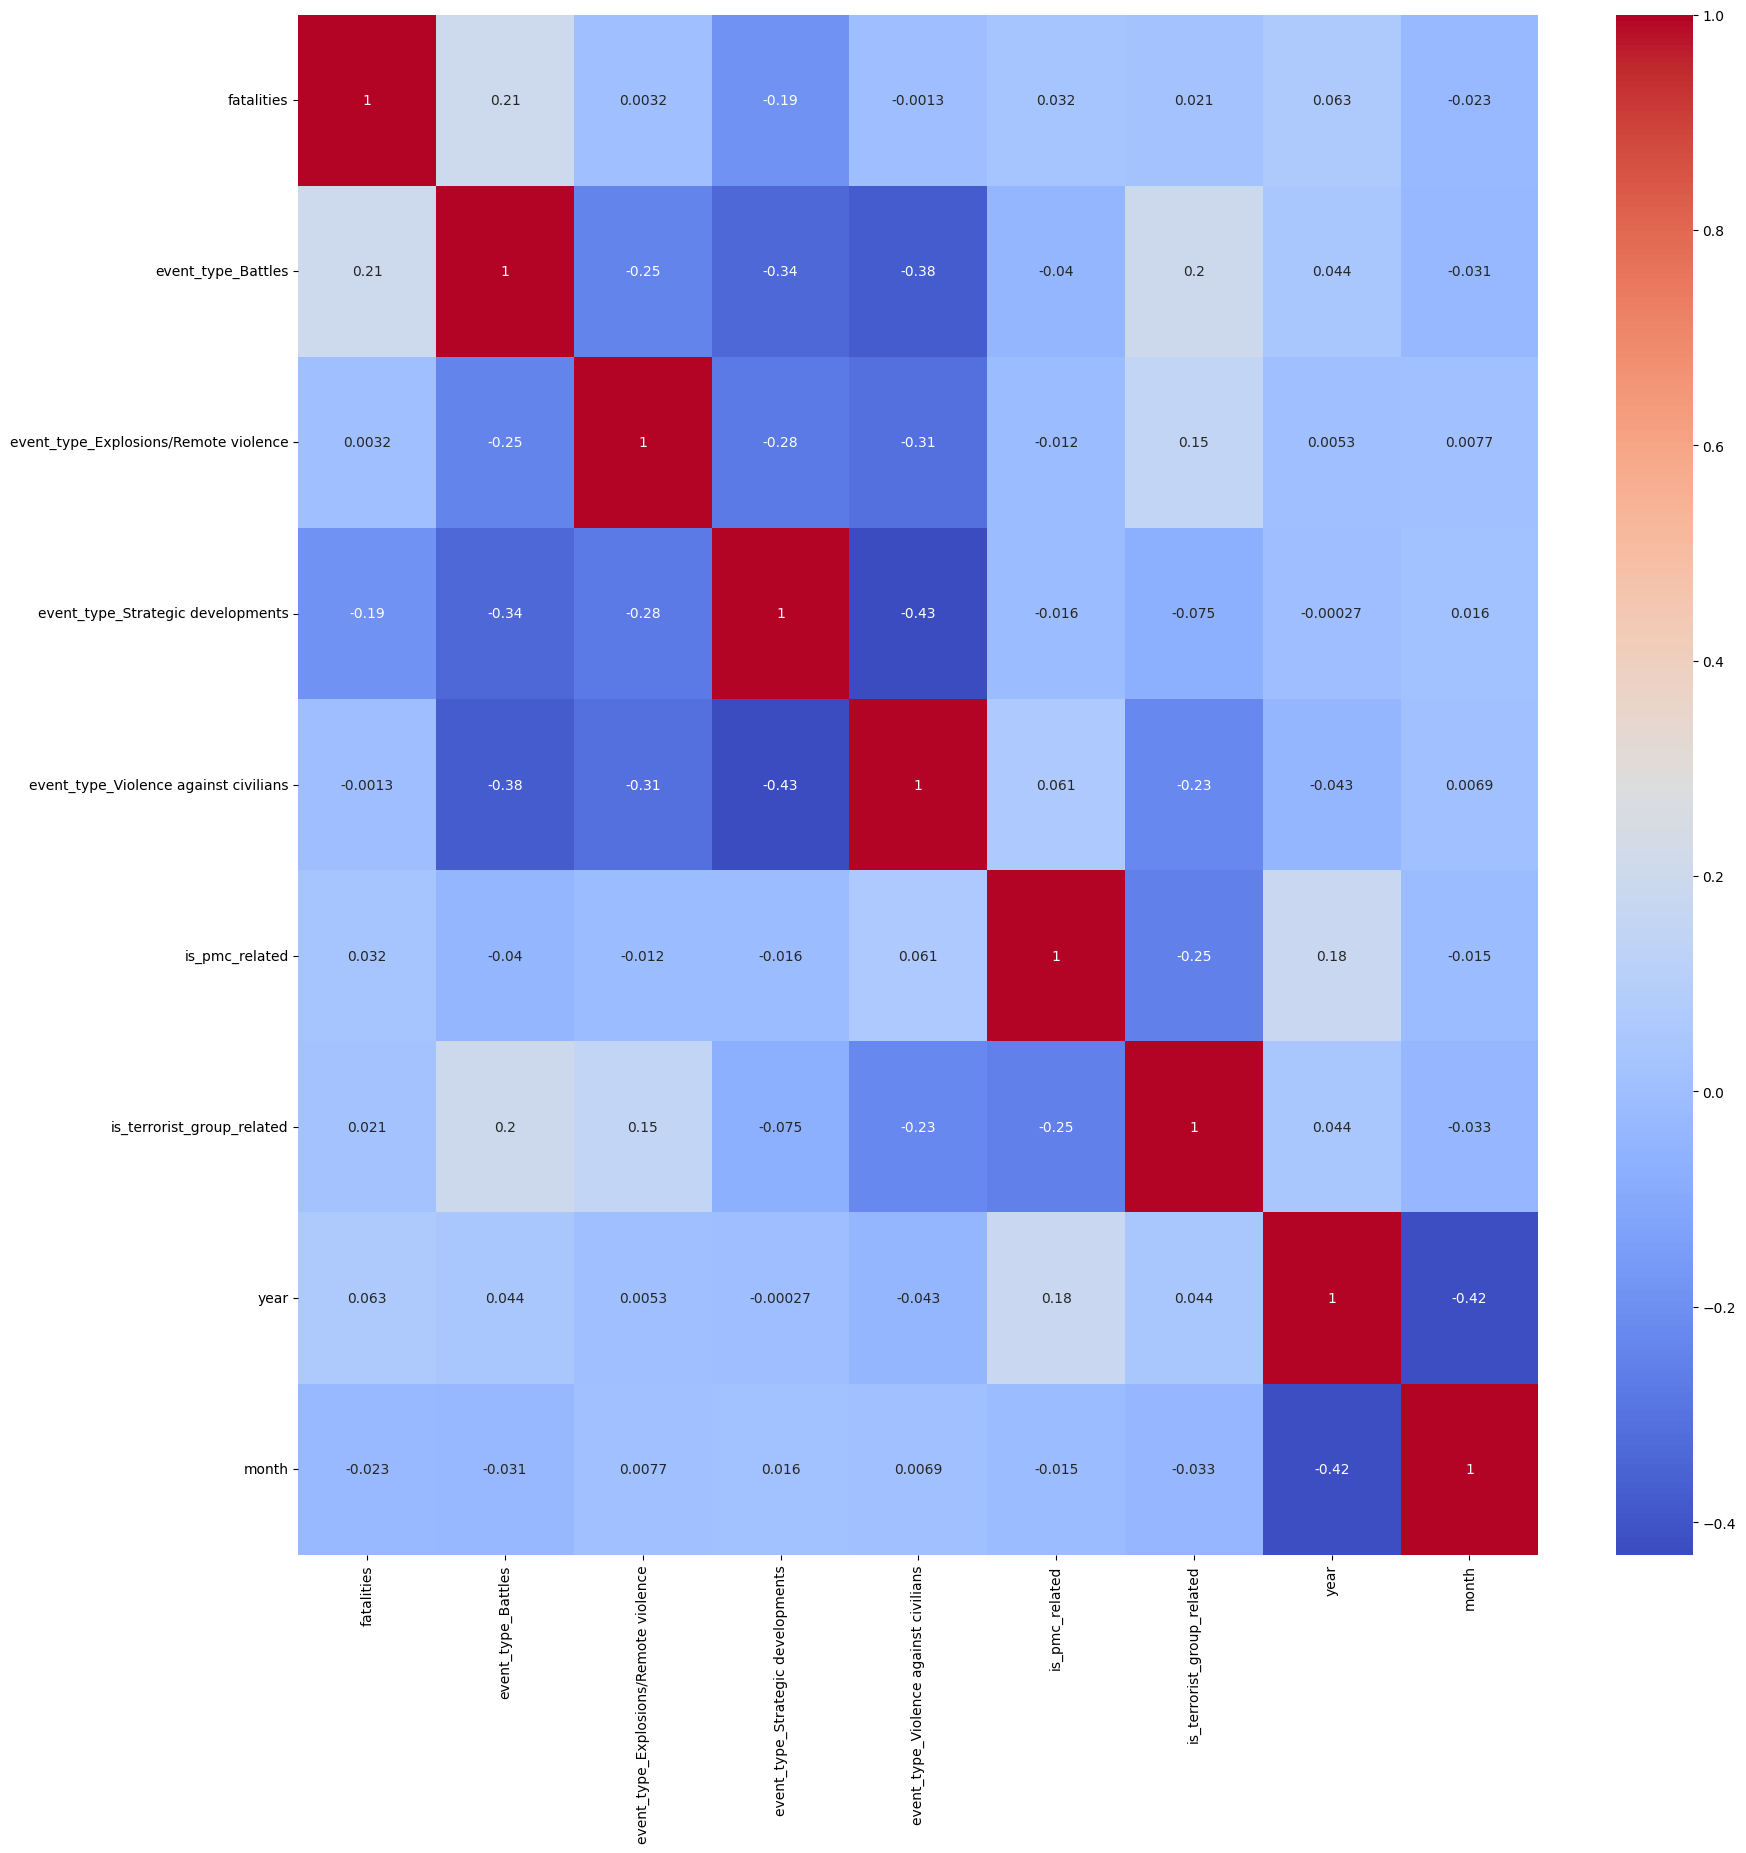

In [2]:
# On cherche ici à voir s'il y a une corrélation entre les évènements (selon le type)
# liés à des groupes terroristes et le nombre de morts, ou le fait que des civils aient été ciblés

# On crée un dataframe pour y appliquer une matrice de corrélation
cat_columns = ['event_type', 'country', 'admin1', 'actor1_type', 'actor2_type', 'interaction_type']
df_encoded = pd.get_dummies(df, columns=cat_columns, dtype=int)

df_cor = df_encoded[['fatalities',
             'event_type_Battles',
             'event_type_Explosions/Remote violence',
             'event_type_Strategic developments',
             'event_type_Violence against civilians',
             'is_pmc_related',
             'is_terrorist_group_related',
             'year',
             'month']]

# On applique la matrice de corrélation
cor = df_cor.corr()
# On trace une heatmap
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(cor, annot = True, ax = ax, cmap = "coolwarm")
plt.show()

/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/1376772104.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  terrorist_events_by_month = df[df['is_terrorist_group_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()
/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/1376772104.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  events_by_month = df.groupby(pd.Grouper(key='event_date', freq='M')).size()


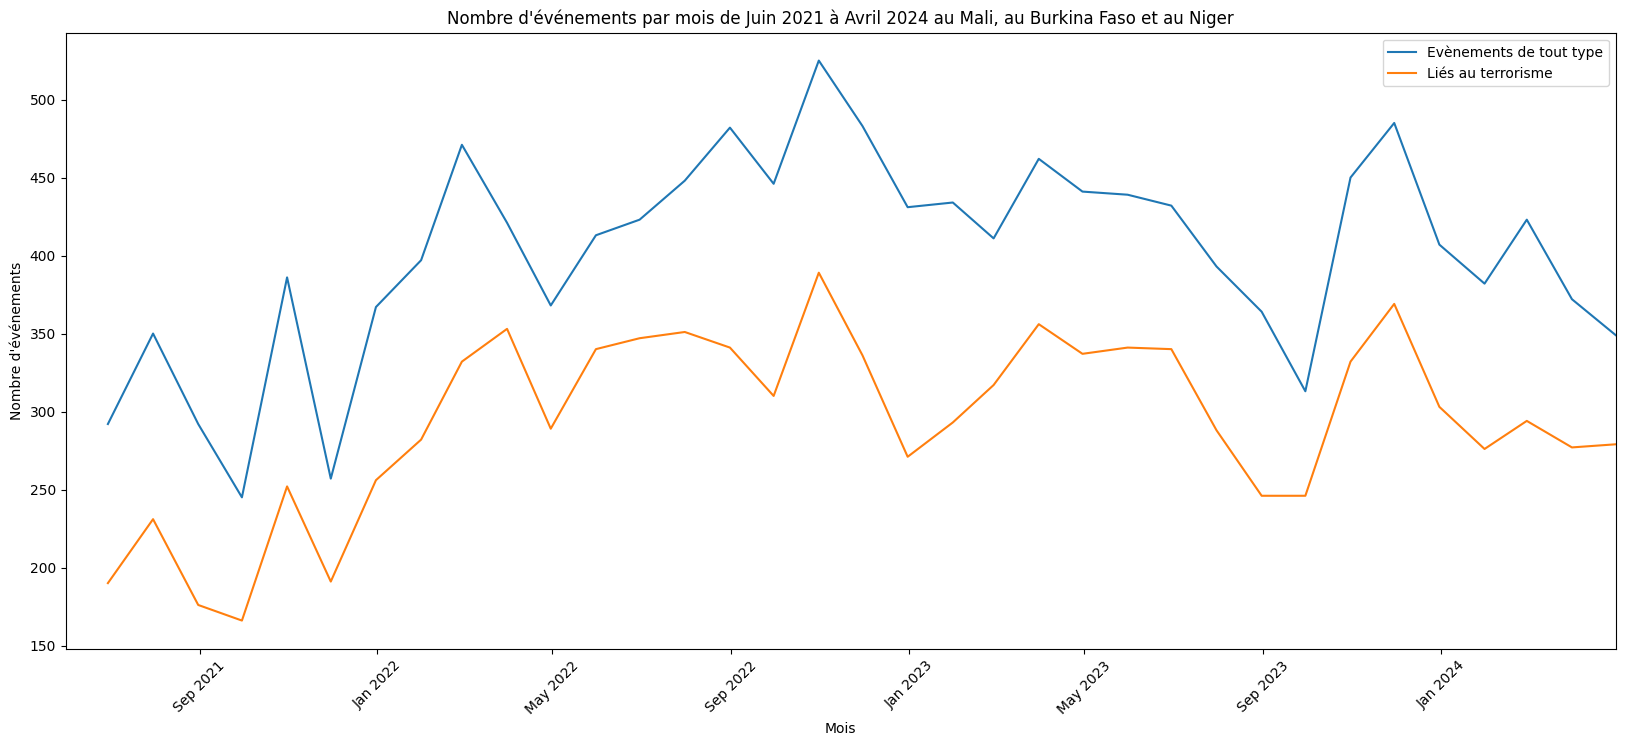

In [3]:
## Nombre d'événements
# par mois de Juin 2021 à Avril 2024
# au Mali, au Burkina Faso et au Niger
# pour tout type d'évènements et ceux liés à des organisations terroristes

# On crée une série qui permet de grouper et de compter par mois
# les évènements liés à des violences perpétrées par des organisations terroristes
terrorist_events_by_month = df[df['is_terrorist_group_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()
# On crée une autre série qui permet de grouper et de compter par mois
# les évènements liés à des violences politiques de manière générale
events_by_month = df.groupby(pd.Grouper(key='event_date', freq='M')).size()

# On trace un diagramme à barres afin d'afficher le nombre d'évènements par mois
# liés à des violences perpétrées par des organisations terroristes
# ainsi que les violences politiques quelque soit l'acteur
plt.figure(figsize=(20, 8))
borne_inf = pd.Timestamp('2021-06-01')
borne_sup = pd.Timestamp('2024-04-30')
plt.xlim(borne_inf, borne_sup)
plt.plot(events_by_month.index, events_by_month.values, label='Evènements de tout type')
plt.plot(terrorist_events_by_month.index, terrorist_events_by_month.values, label='Liés au terrorisme')
plt.xlabel('Mois')
plt.ylabel('Nombre d\'événements')
plt.title('Nombre d\'événements par mois de Juin 2021 à Avril 2024 au Mali, au Burkina Faso et au Niger',
          fontsize=12)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
plt.legend()
plt.show();

/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/4291378747.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouped = df[df['is_terrorist_group_related'] == 1].groupby(['event_type', pd.Grouper(key='event_date', freq='M')]).size().reset_index(name='count')


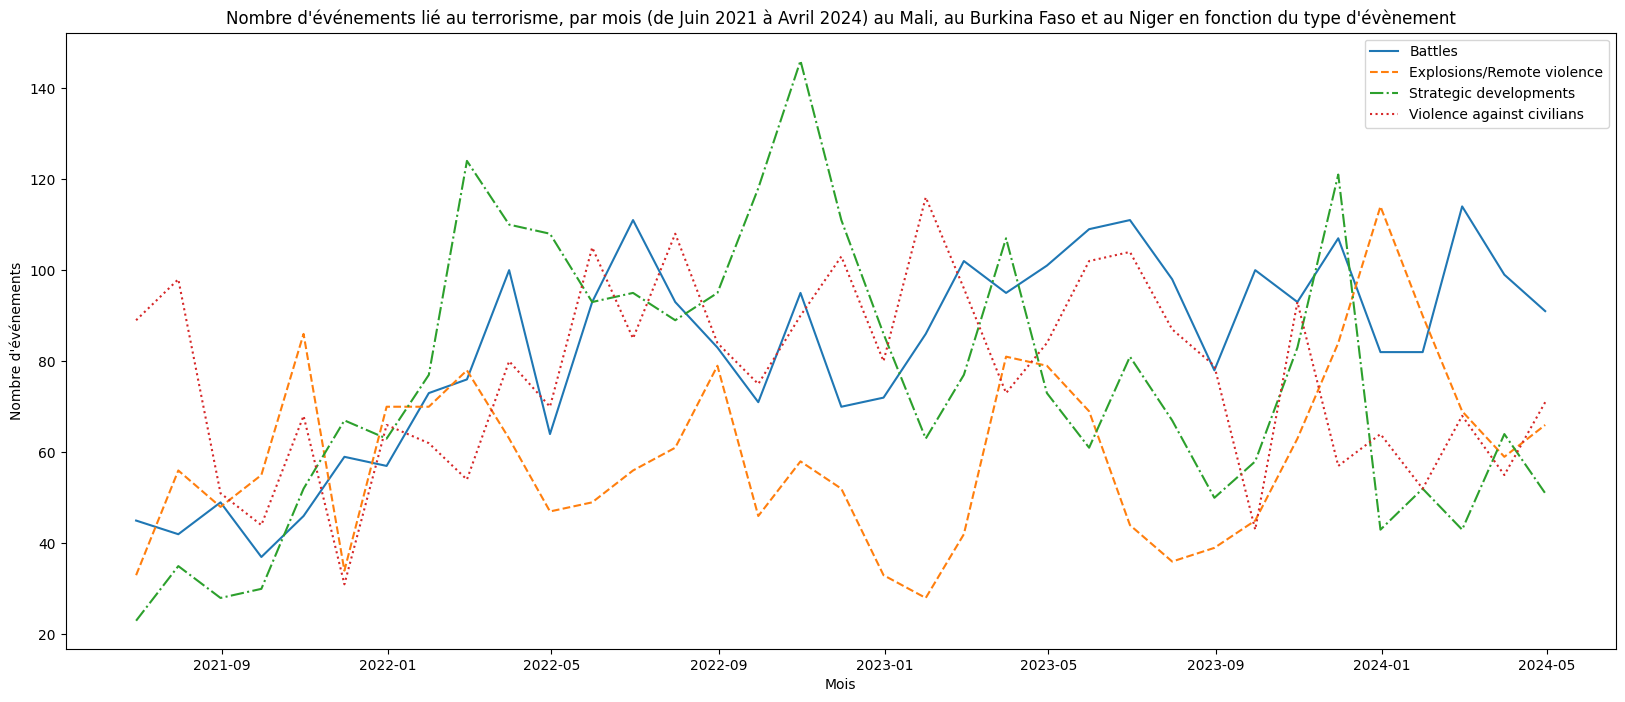

In [4]:
## Nombre d'événements lié au terrorisme
# par mois (de Juin 2021 à Avril 2024)
# au Mali, au Burkina Faso et au Niger
# en fonction du type de violence

# On regroupe les données par mois et par type d'évènement
grouped = df[df['is_terrorist_group_related'] == 1].groupby(['event_type', pd.Grouper(key='event_date', freq='M')]).size().reset_index(name='count')
event_types = grouped['event_type'].unique()
# Ensuite on trace une courbe pour chaque type d'évènement
plt.figure(figsize=(20, 8))
# On va utiliser un type de tracé différent pour chaque type d'évènement
line_styles = ['-', '--', '-.', ':']
for i, event in enumerate(event_types):
    ls = line_styles [i % len(line_styles)] 
    data = grouped[grouped['event_type'] == event]
    plt.plot(data['event_date'], data['count'], label=event, linestyle=ls)

plt.xlabel('Mois')
plt.ylabel('Nombre d\'événements')
plt.title("Nombre d\'événements lié au terrorisme, par mois (de Juin 2021 à Avril 2024) au Mali, au Burkina Faso et au Niger en fonction du type d'évènement",
          fontsize=12)
plt.legend()
plt.show();

/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/3121295679.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  terrorism_by_month_burkina_faso = df_burkina_faso[df_burkina_faso['is_terrorist_group_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()
/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/3121295679.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  terrorism_by_month_mali = df_mali[df_mali['is_terrorist_group_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()
/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/3121295679.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  terrorism_by_month_niger = df_niger[df_niger['is_terrorist_group_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()


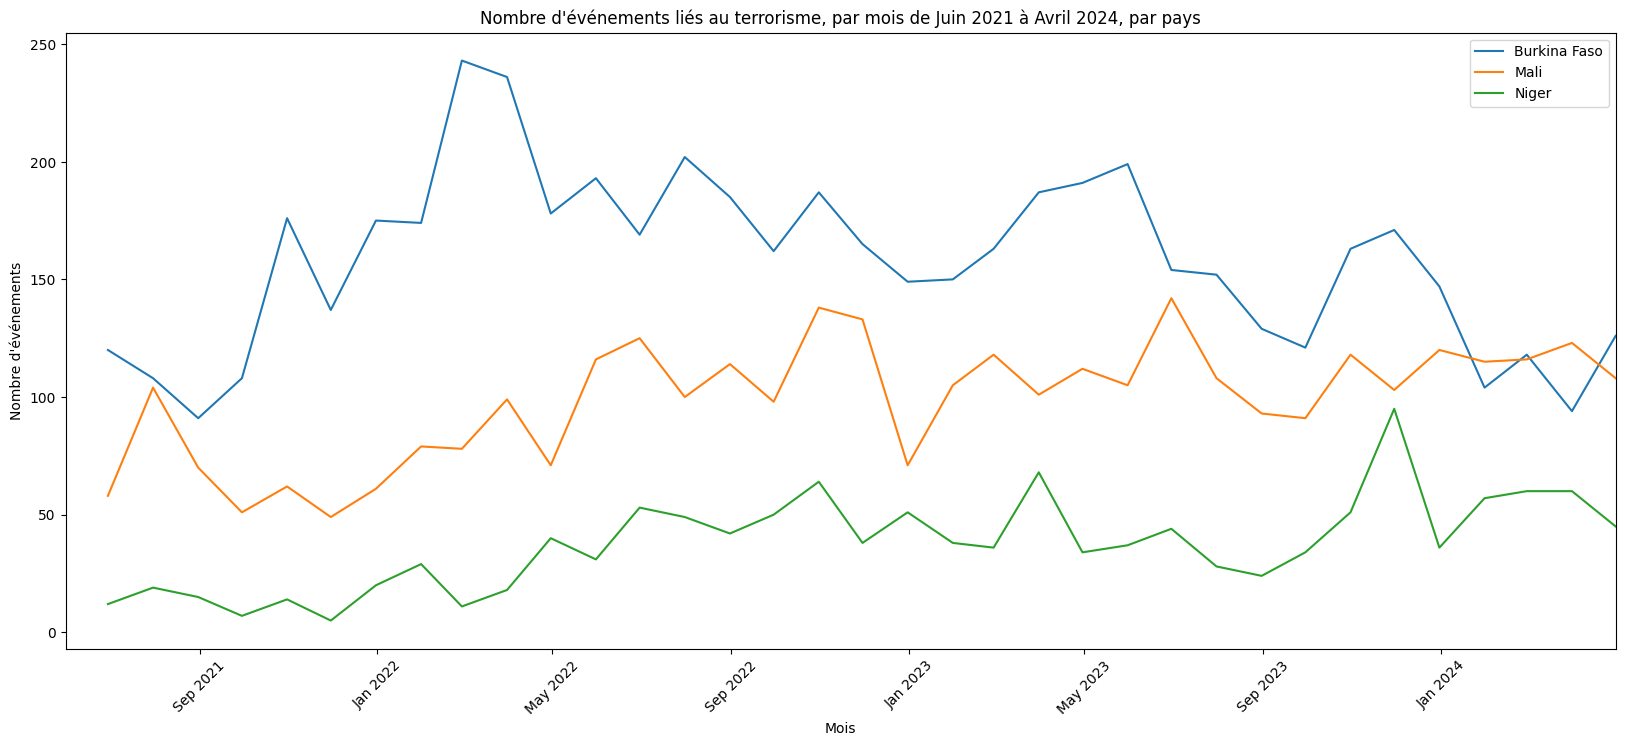

In [5]:
## Nombre d'événements liés au terrorisme
# par mois de Juin 2021 à Avril 2024
# au Mali, au Burkina Faso et au Niger

# On récupère un dataframe par pays
df_burkina_faso = df[df['country'] == 'Burkina Faso']
df_mali = df[df['country'] == 'Mali']
df_niger = df[df['country'] == 'Niger']

# On crée une série qui permet de grouper par mois les évènements liés à des violences perpétrées
# par des organisations terroristes, dans chaque pays étudié
terrorism_by_month_burkina_faso = df_burkina_faso[df_burkina_faso['is_terrorist_group_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()
terrorism_by_month_mali = df_mali[df_mali['is_terrorist_group_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()
terrorism_by_month_niger = df_niger[df_niger['is_terrorist_group_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()

# On trace un diagramme à barres afin d'afficher le nombre d'évènements par mois
# liés à des violences perpétrées par des organisations terroristes
# ainsi que les violences politiques quelque soit l'acteur
plt.figure(figsize=(20, 8))
borne_inf = pd.Timestamp('2021-06-01')
borne_sup = pd.Timestamp('2024-04-30')
plt.xlim(borne_inf, borne_sup)
plt.plot(terrorism_by_month_burkina_faso.index, terrorism_by_month_burkina_faso.values, label='Burkina Faso')
plt.plot(terrorism_by_month_mali.index, terrorism_by_month_mali.values, label='Mali')
plt.plot(terrorism_by_month_niger.index, terrorism_by_month_niger.values, label='Niger')
plt.xlabel('Mois')
plt.ylabel('Nombre d\'événements')
plt.title('Nombre d\'événements liés au terrorisme, par mois de Juin 2021 à Avril 2024, par pays',
          fontsize=12)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
plt.legend()
plt.show();

/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/134555086.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  terrorism_ei = df[(df['is_terrorist_group_related'] == 1) & (df['terrorist_group_filiation'] == 'Etat Islamique')].groupby(pd.Grouper(key='event_date', freq='M')).size()
/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/134555086.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  terrorism_aq = df[(df['is_terrorist_group_related'] == 1) & (df['terrorist_group_filiation'] == 'Al Qaida')].groupby(pd.Grouper(key='event_date', freq='M')).size()


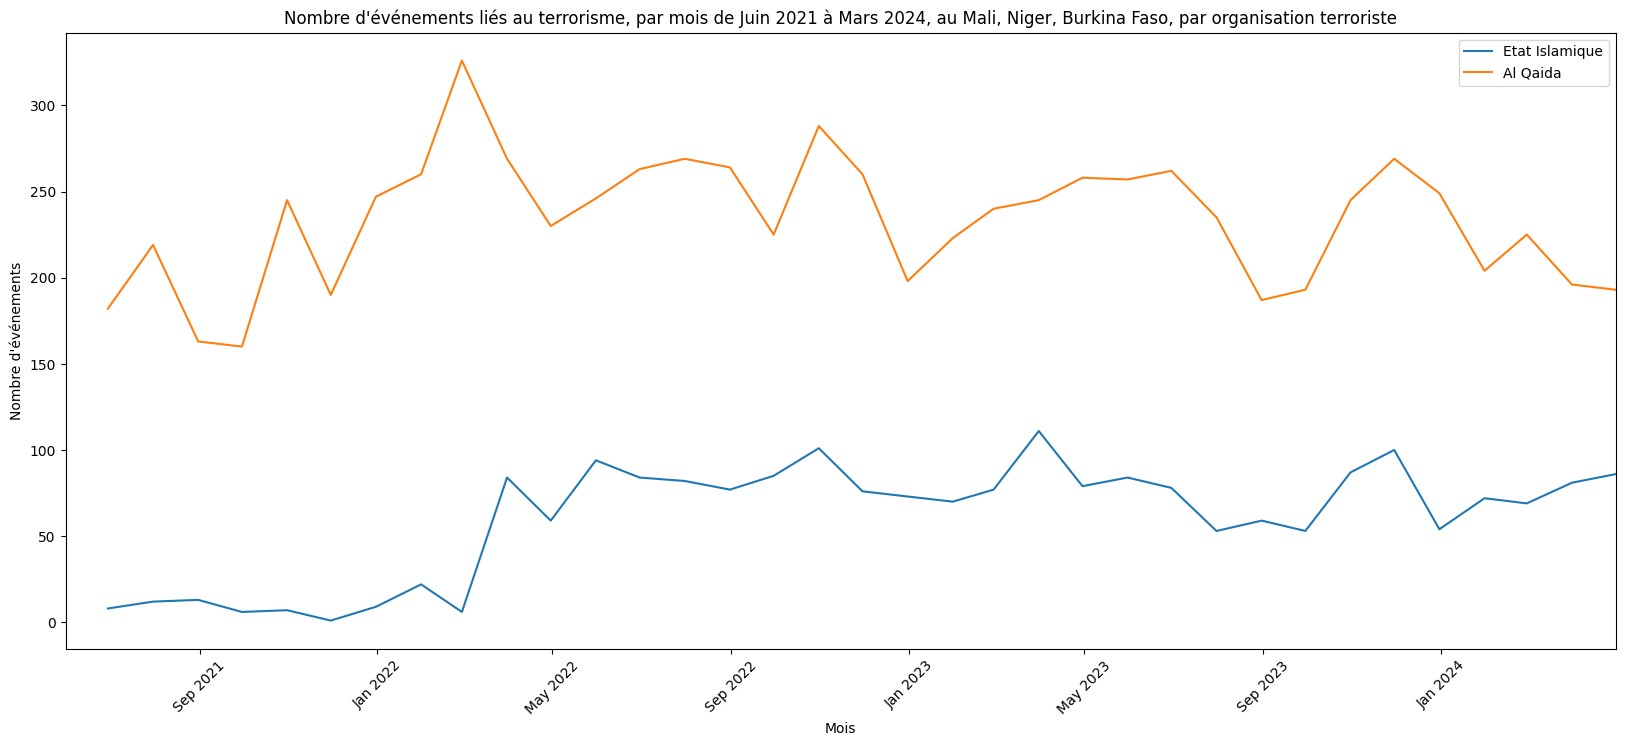

In [6]:
## Nombre d'événements liés au terrorisme
# par mois de Juin 2021 à Avril 2024
# au Mali, au Niger et au Burkina Faso
# par organisation terroriste mère

# On crée une série qui permet de grouper par mois les évènements liés à des violences perpétrées
# par chaque organisation terroriste mère, # au Mali, au Niger et au Burkina Faso
terrorism_ei = df[(df['is_terrorist_group_related'] == 1) & (df['terrorist_group_filiation'] == 'Etat Islamique')].groupby(pd.Grouper(key='event_date', freq='M')).size()
terrorism_aq = df[(df['is_terrorist_group_related'] == 1) & (df['terrorist_group_filiation'] == 'Al Qaida')].groupby(pd.Grouper(key='event_date', freq='M')).size()


# On trace un diagramme à barres afin d'afficher le nombre d'évènements par mois
# liés à des violences perpétrées par des organisations terroristes
# ainsi que les violences politiques quelque soit l'acteur
plt.figure(figsize=(20, 8))
borne_inf = pd.Timestamp('2021-06-01')
borne_sup = pd.Timestamp('2024-04-30')
plt.xlim(borne_inf, borne_sup)
plt.plot(terrorism_ei.index, terrorism_ei.values, label='Etat Islamique')
plt.plot(terrorism_aq.index, terrorism_aq.values, label='Al Qaida')
plt.xlabel('Mois')
plt.ylabel('Nombre d\'événements')
plt.title('Nombre d\'événements liés au terrorisme, par mois de Juin 2021 à Mars 2024, au Mali, Niger, Burkina Faso, par organisation terroriste',
          fontsize=12)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
plt.legend()
plt.show();

/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/1048050811.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  terrorism_mali_ei = df_mali[(df_mali['is_terrorist_group_related'] == 1) & (df_mali['terrorist_group_filiation'] == 'Etat Islamique')].groupby(pd.Grouper(key='event_date', freq='M')).size()
/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/1048050811.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  terrorism_mali_aq = df_mali[(df_mali['is_terrorist_group_related'] == 1) & (df_mali['terrorist_group_filiation'] == 'Al Qaida')].groupby(pd.Grouper(key='event_date', freq='M')).size()


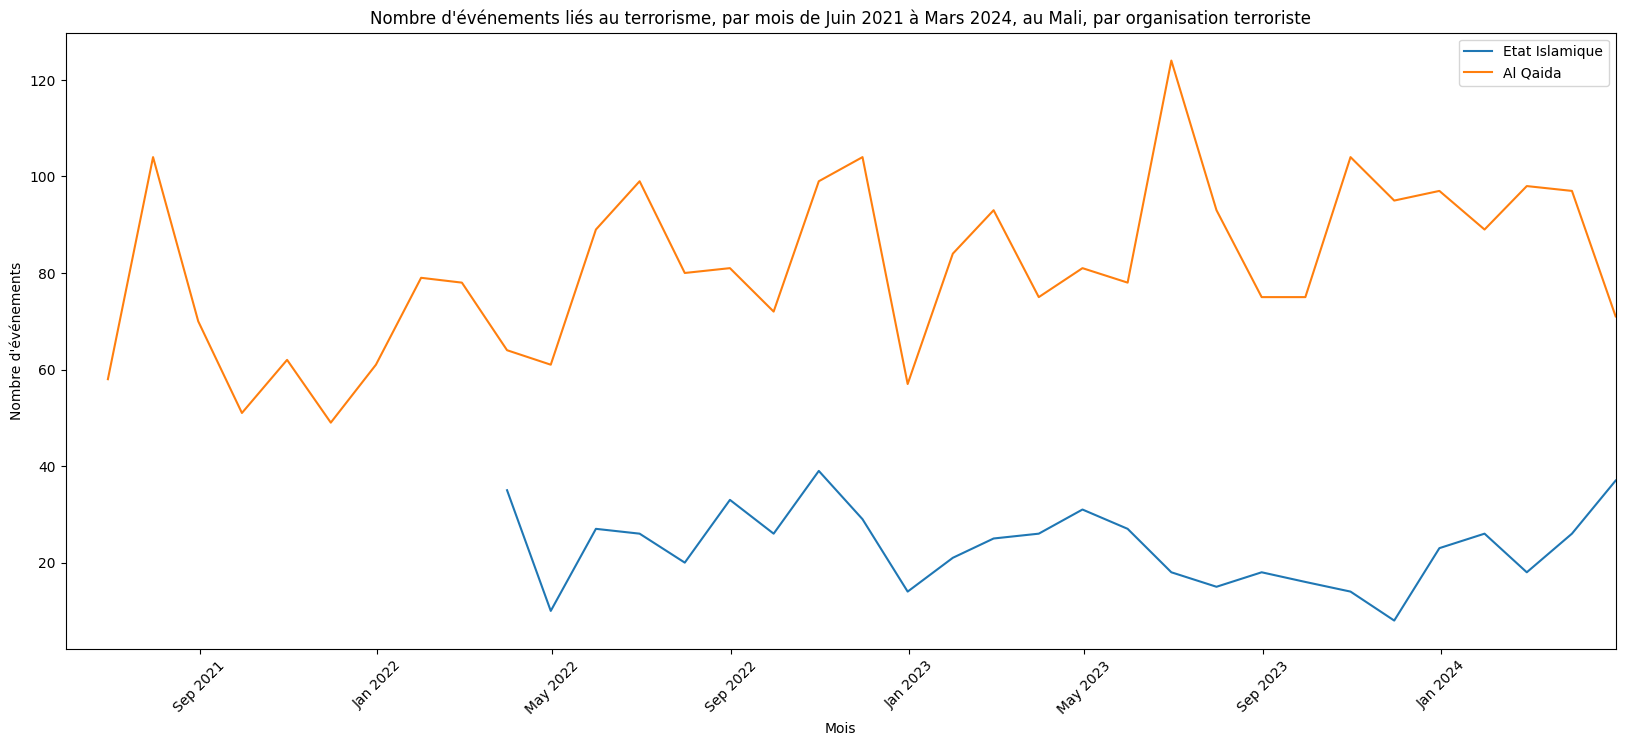

In [7]:
## Nombre d'événements liés au terrorisme
# par mois de Juin 2021 à Avril 2024
# au Mali
# par organisation terroriste mère

# On filtre notre dataframe sur le Mali uniquement
df_mali = df[df['country'] == 'Mali']

# On crée une série qui permet de grouper par mois les évènements liés à des violences perpétrées
# par chaque organisation terroriste mère, au Mali
terrorism_mali_ei = df_mali[(df_mali['is_terrorist_group_related'] == 1) & (df_mali['terrorist_group_filiation'] == 'Etat Islamique')].groupby(pd.Grouper(key='event_date', freq='M')).size()
terrorism_mali_aq = df_mali[(df_mali['is_terrorist_group_related'] == 1) & (df_mali['terrorist_group_filiation'] == 'Al Qaida')].groupby(pd.Grouper(key='event_date', freq='M')).size()


# On trace un diagramme à barres afin d'afficher le nombre d'évènements par mois
# liés à des violences perpétrées par des organisations terroristes
# ainsi que les violences politiques quelque soit l'acteur
plt.figure(figsize=(20, 8))
borne_inf = pd.Timestamp('2021-06-01')
borne_sup = pd.Timestamp('2024-04-30')
plt.xlim(borne_inf, borne_sup)
plt.plot(terrorism_mali_ei.index, terrorism_mali_ei.values, label='Etat Islamique')
plt.plot(terrorism_mali_aq.index, terrorism_mali_aq.values, label='Al Qaida')
plt.xlabel('Mois')
plt.ylabel('Nombre d\'événements')
plt.title('Nombre d\'événements liés au terrorisme, par mois de Juin 2021 à Mars 2024, au Mali, par organisation terroriste',
          fontsize=12)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
plt.legend()
plt.show();

/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/1686682113.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  wagner_events_by_month = df[df['is_pmc_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()


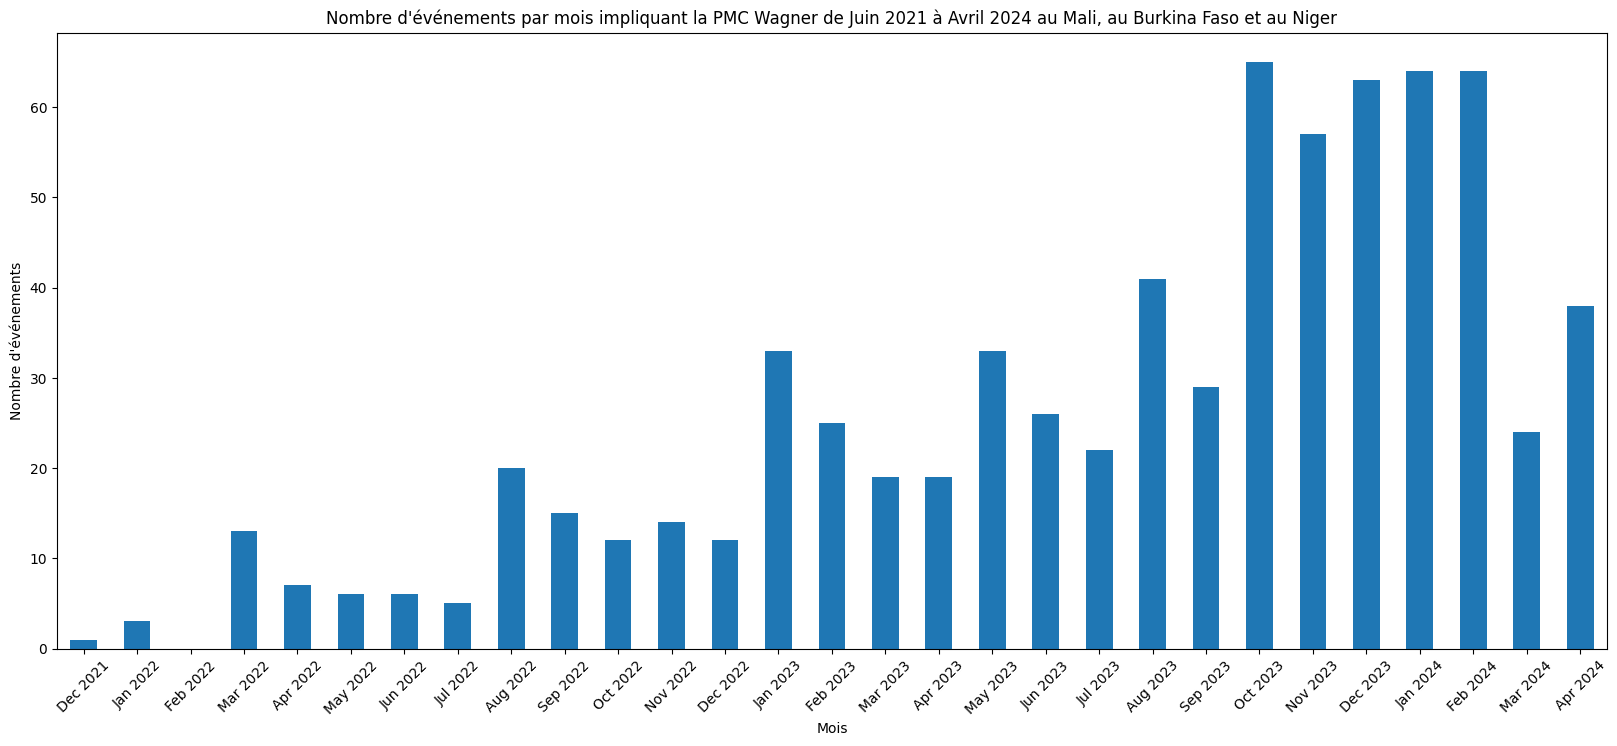

In [8]:
## Nombre d'événements impliquant la PMC Wagner
# par mois de Juin 2021 à Avril 2024
# au Mali, au Burkina Faso et au Niger

# On crée une série qui permet de grouper et de compter par mois
# les évènements liés à des actions de Wagner
wagner_events_by_month = df[df['is_pmc_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()

# On trace un diagramme à barres afin d'afficher le nombre d'évènements par mois
# liés à des violences perpétrées par des organisations terroristes
# ainsi que les violences politiques quelque soit l'acteur
plt.figure(figsize=(20, 8))
plt.xlim(borne_inf, borne_sup)
wagner_events_by_month.plot(kind='bar', legend=False)
plt.xlabel('Mois')
plt.ylabel('Nombre d\'événements')
plt.title('Nombre d\'événements par mois impliquant la PMC Wagner de Juin 2021 à Avril 2024 au Mali, au Burkina Faso et au Niger',
          fontsize=12)

# On affiche uniquement le mois et l'année en abscisse
plt.xticks(ticks=range(len(wagner_events_by_month.index)),
           labels=[date.strftime('%b %Y') for date in wagner_events_by_month.index], rotation=45)
plt.show();

/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/88491662.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pmc_events_by_month_burkina_faso = df_burkina_faso[df_burkina_faso['is_pmc_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()
/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/88491662.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pmc_events_by_month_mali = df_mali[df_mali['is_pmc_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()
/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/88491662.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pmc_events_by_month_niger = df_niger[df_niger['is_pmc_related'] ==  1].groupby(pd.Grouper(key='event_date', freq='M')).size()


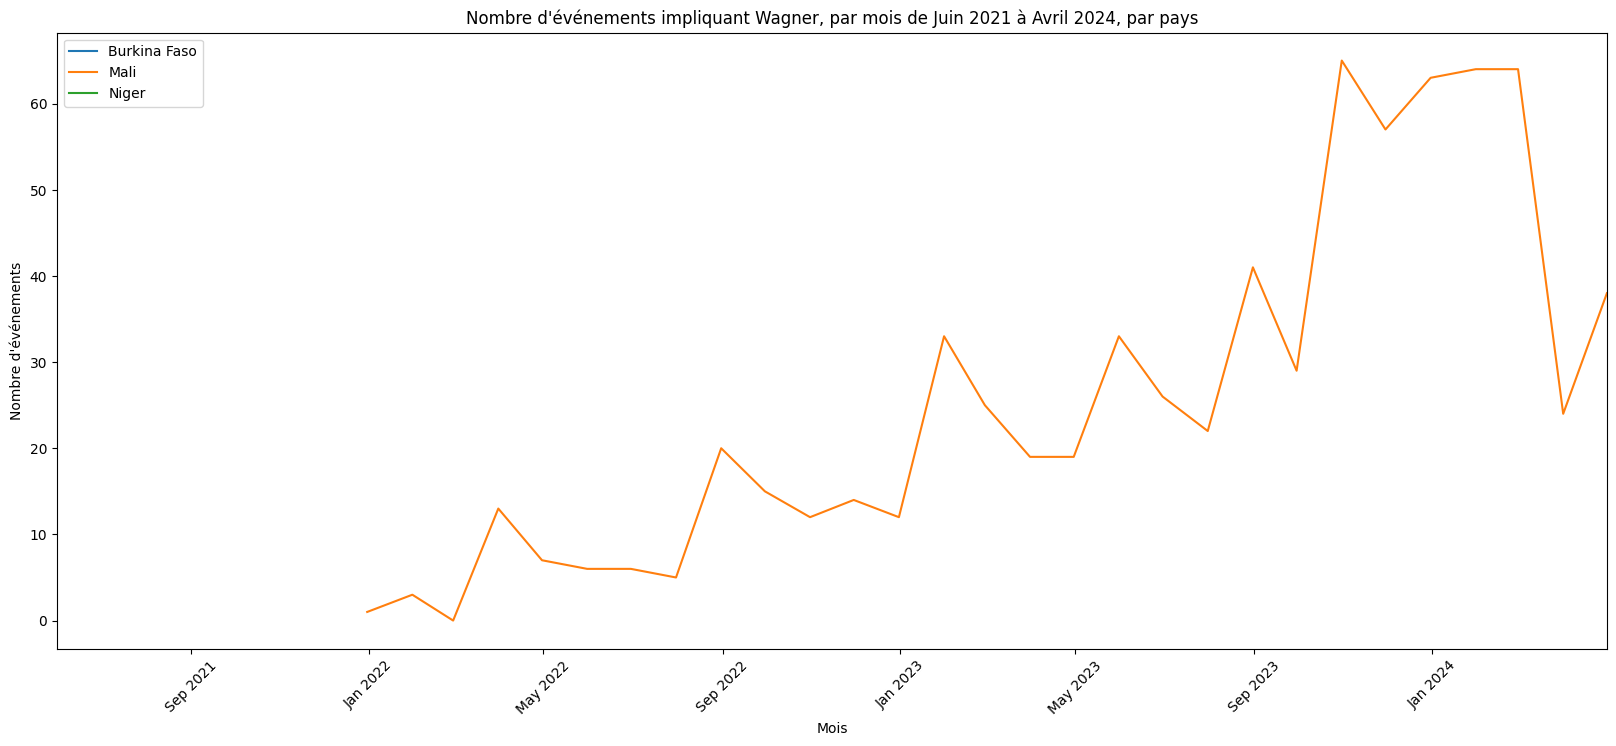

In [9]:
## Nombre d'événements impliquant Wagner
# par mois de Juin 2021 à Avril 2024
# par pays

# On crée une série qui permet de grouper par mois les évènements liés
# à des pmc russes dans chaque pays étudié
pmc_events_by_month_burkina_faso = df_burkina_faso[df_burkina_faso['is_pmc_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()
pmc_events_by_month_mali = df_mali[df_mali['is_pmc_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()
pmc_events_by_month_niger = df_niger[df_niger['is_pmc_related'] ==  1].groupby(pd.Grouper(key='event_date', freq='M')).size()

# On trace un diagramme à barres afin d'afficher le nombre d'évènements par mois
# liés à des violences perpétrées par des organisations terroristes
# ainsi que les violences politiques quelque soit l'acteur
plt.figure(figsize=(20, 8))
borne_inf = pd.Timestamp('2021-06-01')
borne_sup = pd.Timestamp('2024-04-30')
plt.xlim(borne_inf, borne_sup)
plt.plot(pmc_events_by_month_burkina_faso.index, pmc_events_by_month_burkina_faso.values, label='Burkina Faso')
plt.plot(pmc_events_by_month_mali.index, pmc_events_by_month_mali.values, label='Mali')
plt.plot(pmc_events_by_month_niger.index, pmc_events_by_month_niger.values, label='Niger')
plt.xlabel('Mois')
plt.ylabel('Nombre d\'événements')
plt.title('Nombre d\'événements impliquant Wagner, par mois de Juin 2021 à Avril 2024, par pays',
          fontsize=12)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
plt.legend()
plt.show();

/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/1549544408.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  events_mali = df_mali.groupby(pd.Grouper(key='event_date', freq='M')).size()
/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/1549544408.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  terrorism_mali = df_mali[df_mali['is_terrorist_group_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()
/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/1549544408.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pmc_mali = df_mali[df_mali['is_pmc_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()
/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/1549544408.py:13: FutureWarning: 'M' is deprecated and will be removed in a futu

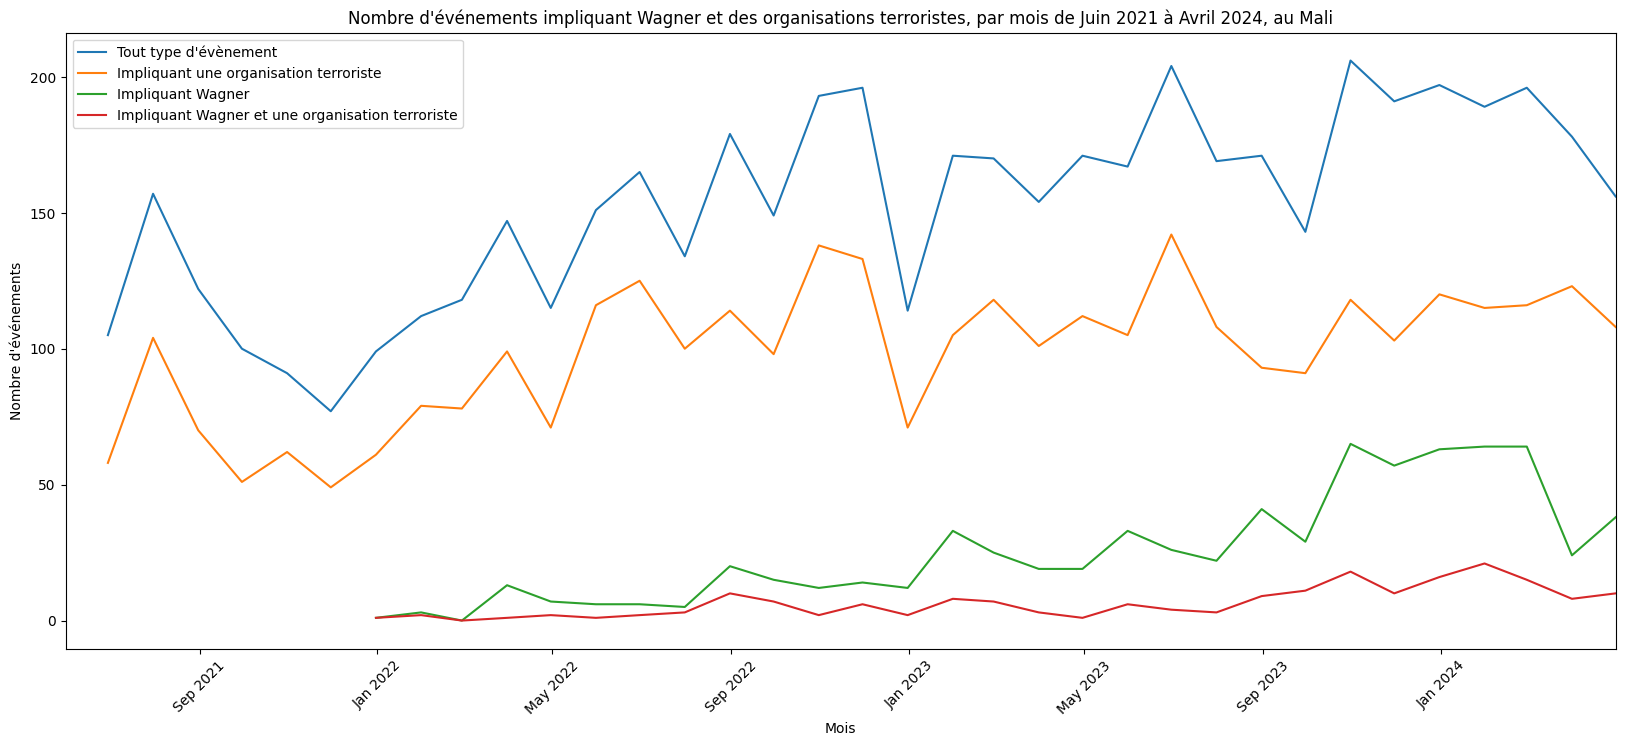

In [10]:
## Nombre d'événements impliquant Wagner et des organisations terroristes
# par mois de Juin 2021 à Avril 2024
# au Mali

# On filtre notre dataframe sur le Mali uniquement
df_mali = df[df['country'] == 'Mali']

# On crée une série qui permet de grouper par mois les évènements liés à des violences perpétrées
# par chaque organisation terroriste mère, au Mali
events_mali = df_mali.groupby(pd.Grouper(key='event_date', freq='M')).size()
terrorism_mali = df_mali[df_mali['is_terrorist_group_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()
pmc_mali = df_mali[df_mali['is_pmc_related'] == 1].groupby(pd.Grouper(key='event_date', freq='M')).size()
terrorism_pmc_mali = df_mali[(df_mali['is_terrorist_group_related'] == 1) & (df_mali['is_pmc_related'] == 1)].groupby(pd.Grouper(key='event_date', freq='M')).size()

# On trace un diagramme à barres afin d'afficher le nombre d'évènements par mois
# liés à des violences perpétrées par des organisations terroristes
# ainsi que les violences politiques quelque soit l'acteur
plt.figure(figsize=(20, 8))
borne_inf = pd.Timestamp('2021-06-01')
borne_sup = pd.Timestamp('2024-04-30')
plt.xlim(borne_inf, borne_sup)
plt.plot(events_mali.index, events_mali.values, label="Tout type d'évènement")
plt.plot(terrorism_mali.index, terrorism_mali.values, label='Impliquant une organisation terroriste')
plt.plot(pmc_mali.index, pmc_mali.values, label='Impliquant Wagner')
plt.plot(terrorism_pmc_mali.index, terrorism_pmc_mali.values, label='Impliquant Wagner et une organisation terroriste')
plt.xlabel('Mois')
plt.ylabel('Nombre d\'événements')
plt.title('Nombre d\'événements impliquant Wagner et des organisations terroristes, par mois de Juin 2021 à Avril 2024, au Mali',
          fontsize=12)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
plt.legend()
plt.show();

/var/folders/x5/kcw41vd12jgcfb19y5bzyc880000gn/T/ipykernel_2565/2820121638.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouped = df.groupby(['event_type', pd.Grouper(key='event_date', freq='M')]).size().reset_index(name='count')


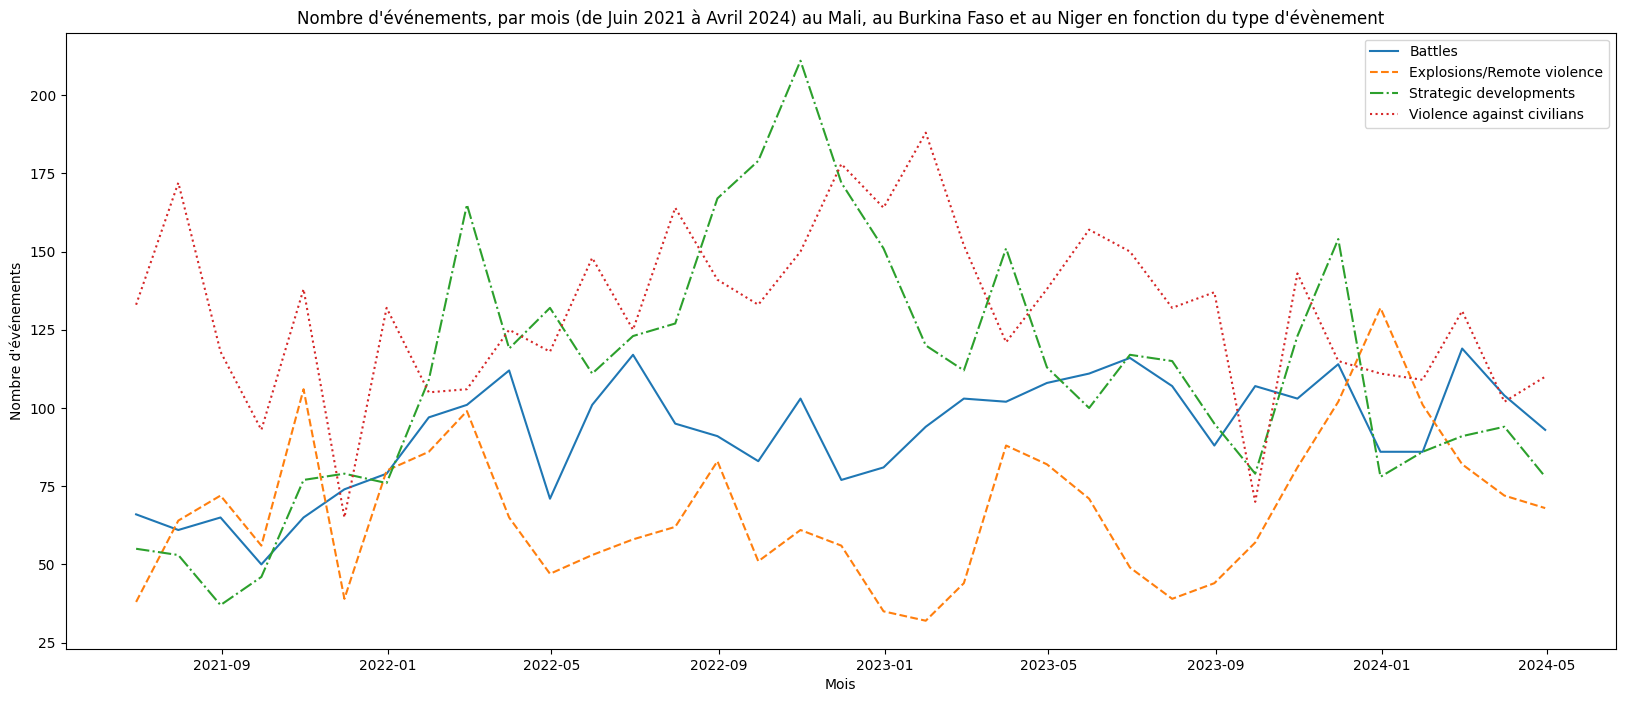

In [11]:
## Nombre d'événements
# par mois (de Juin 2021 à Avril 2024)
# au Mali, au Burkina Faso et au Niger
# en fonction du type de violence

# On regroupe les données par mois et par type d'évènement
grouped = df.groupby(['event_type', pd.Grouper(key='event_date', freq='M')]).size().reset_index(name='count')
event_types = grouped['event_type'].unique()
# Ensuite on trace une courbe pour chaque type d'évènement
plt.figure(figsize=(20, 8))
# On va utiliser un type de tracé différent pour chaque type d'évènement
line_styles = ['-', '--', '-.', ':']
for i, event in enumerate(event_types):
    ls = line_styles [i % len(line_styles)] 
    data = grouped[grouped['event_type'] == event]
    plt.plot(data['event_date'], data['count'], label=event, linestyle=ls)

plt.xlabel('Mois')
plt.ylabel('Nombre d\'événements')
plt.title("Nombre d\'événements, par mois (de Juin 2021 à Avril 2024) au Mali, au Burkina Faso et au Niger en fonction du type d'évènement",
          fontsize=12)
plt.legend()
plt.show();